In [1]:
## data processing
import pandas as pd
import numpy as np
from numpy import ma
from collections import Counter
import math

## plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib import ticker, cm
from matplotlib.pyplot import figure
import seaborn as sns

## modeling
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.manifold import TSNE 
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import tensorflow as tf
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.dif import DIF
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA
from pyod.models.gmm import GMM
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore")

<div class="anchor" id="top" style=" margin-right: auto; margin-left: auto; padding: 10px; font-size : 15px; background-color: #DFFFFE; border-radius: 2px; font-color :  #581845  ; border: 2px solid #581845;"> 

Credit Card Fraud Detection - Anonymized credit card transactions labeled as fraudulent or genuine. **The task of detecting fraud in a bank transaction.**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

GitHub: https://github.com/Gracee2024/5632-final

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 15px;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
 
- [1. Dataset Description](#1)
- [2. EXPLORATORY DATA ANALYSIS](#2)
    - [2.1 BASIC STATISTICS](#2.1)
    - [2.2 NORMAL VS FRAUD](#2.2)
    - [2.3 DATA IMBALANCE CHECK](#2.3)
    - [2.4 DUPLICATED VALUES](#2.4)
- [3. MODEL BUILDING AND TRAINING](#3)
    - [3.1 PREPROCESS](#3.1)
    - [3.2 MULTI-VARIATE GAUSSIAN PROB DISTRIBUTION](#3.2)
    - [3.3 AUTOENCODER](#33-autoencoder)
    - [3.4 LOCAL OUTLIER FACTOR](#34-local-outlier-factor-lof)
    - [3.5 ISOLATION FOREST](#35-isolation-forest)
- [4. CONCLUSIONS](#4)


# <a id="1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">DATASET DESCRIPTION</p>   </span></font></center> 
# 1. DATASET DESCRIPTION
<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">
    
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Dataset contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## creditcard.csv
- `Time`: Number of seconds elapsed between this transaction and the first transaction in the dataset
- `V1-V28`: Features after dimensionality reduction to protect user identities and sensitive features
- `Amount`: Transaction amount
- `Class`: Target Class (1 for fraudulent transactions, 0 genuine)


Data Source By:
- https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
num_rows, num_columns = df.shape

print("Data:")
print(f"Number of Rows: {num_rows}")
print(f"Number of Columns: {num_columns}\n")

Data:
Number of Rows: 284807
Number of Columns: 31



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# <a id="2"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px"> EXPLORATORY DATA ANALYSIS </p>   </span></font></center> 
# 2. EXPLORATORY DATA ANALYSIS

## 2.1 BASIC STATISTICS

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df['Hour'] = df['Time'].apply(lambda x:divmod(x,3600)[0])
label = df['Class']
df = df.drop("Class", axis=1)
df["Class"] = label
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Class
281877,170486.0,1.867608,-0.589577,-1.055278,0.546316,-0.319884,-0.436945,-0.211266,-0.020336,1.039442,...,-0.193756,0.210395,0.646751,-0.290727,0.189157,-0.067973,-0.036217,89.95,47.0,0
42247,41013.0,1.152158,-0.323828,0.508440,0.225895,-0.459226,0.327780,-0.579368,0.215598,0.416168,...,-0.180071,-0.135532,-0.830067,0.233093,0.443248,-0.026890,0.012615,61.56,11.0,0
83264,59763.0,1.154257,-0.376704,0.355840,0.433925,-0.658204,-0.378249,-0.173630,-0.127969,-1.148684,...,-0.970710,0.091128,0.022581,0.263936,-0.541901,0.050202,0.042589,81.78,16.0,0
208714,137240.0,1.386660,-1.400024,0.380877,1.631918,-1.286313,1.114508,-1.157283,0.484541,1.757419,...,0.838446,-0.016521,0.769895,-0.320806,-0.601124,0.063508,0.019530,238.26,38.0,0
185272,126601.0,1.967196,0.697405,-1.597726,3.591960,1.130292,-0.172581,0.719272,-0.198489,-1.535626,...,0.415552,-0.083527,-0.498850,0.440267,0.183451,-0.085933,-0.083211,7.95,35.0,0


In [8]:
normal_data = df[df["Class"] == 0]
fraud_data = df[df["Class"] == 1]

## 2.2 NORMAL VS FRAUD

In [9]:
normal_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,25.852463,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,13.183680,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,15.000000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,23.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,38.000000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,47.000000,0.0


In [10]:
fraud_data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Hour,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,21.939024,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,13.283389,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,11.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,20.000000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,35.000000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,47.000000,1.0


In [11]:
normal_data = df[df["Class"] == 0]
fraud_data = df[df["Class"] == 1]

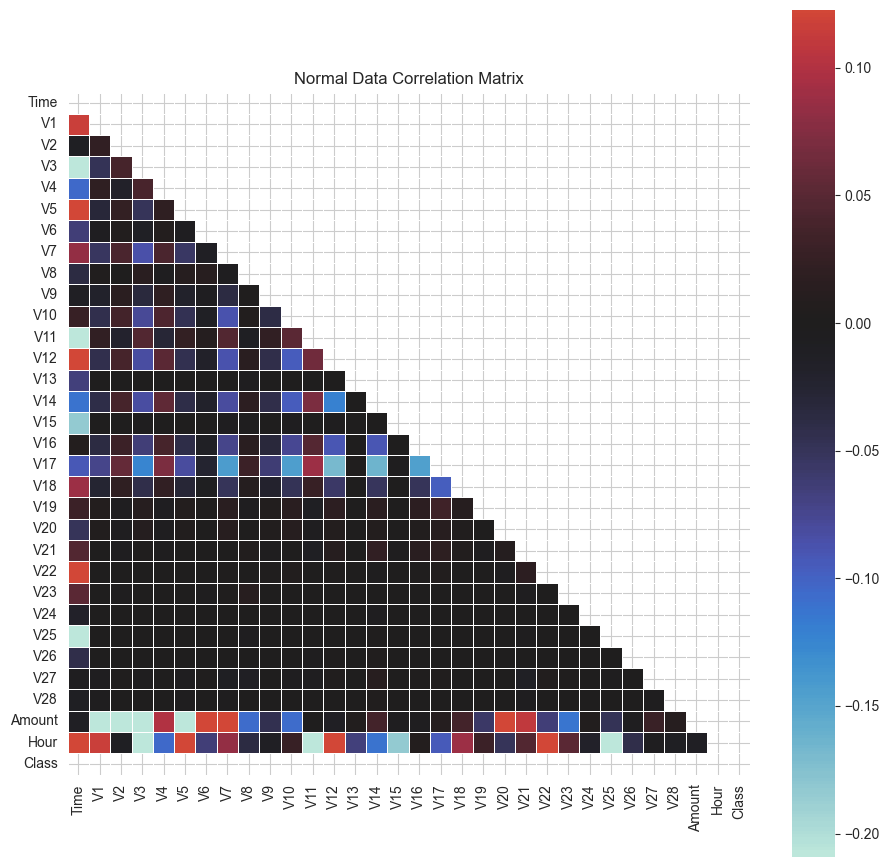

In [12]:
plt.figure(figsize = (11,11))
corr = normal_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6)
plt.title('Normal Data Correlation Matrix')
# plt.savefig('normal correlation_matrix.svg')
plt.show()

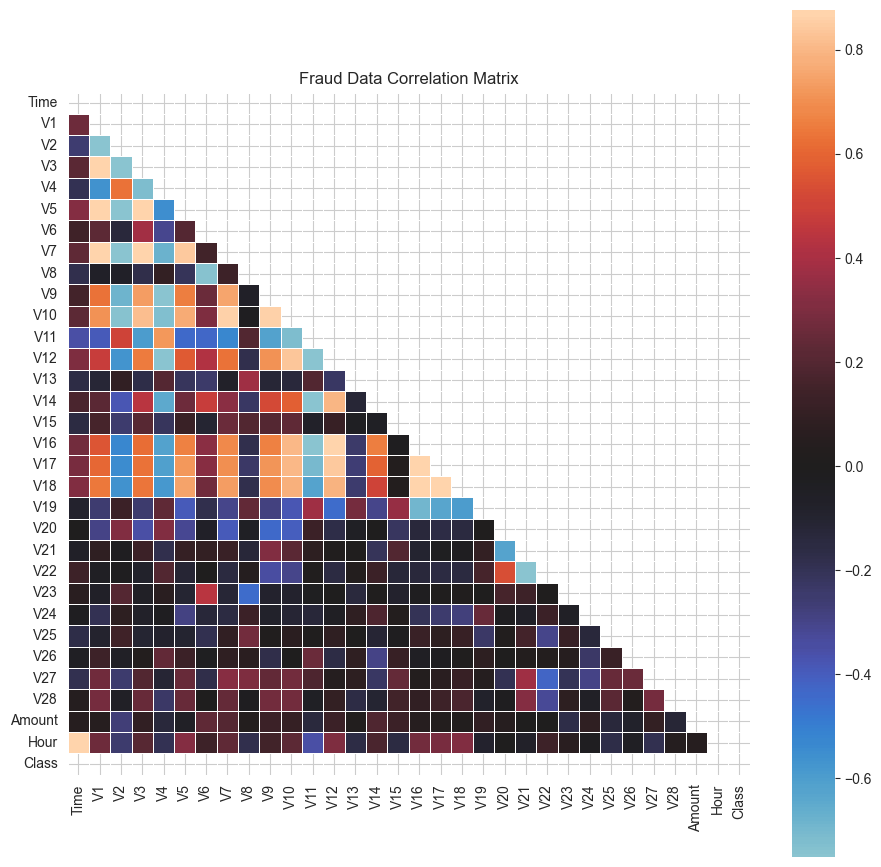

In [13]:
plt.figure(figsize = (11,11))
corr = fraud_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, robust = True, center = 0,square = True, linewidths = .6)
plt.title('Fraud Data Correlation Matrix')
# plt.savefig('fraud correlation_matrix.svg')
plt.show()

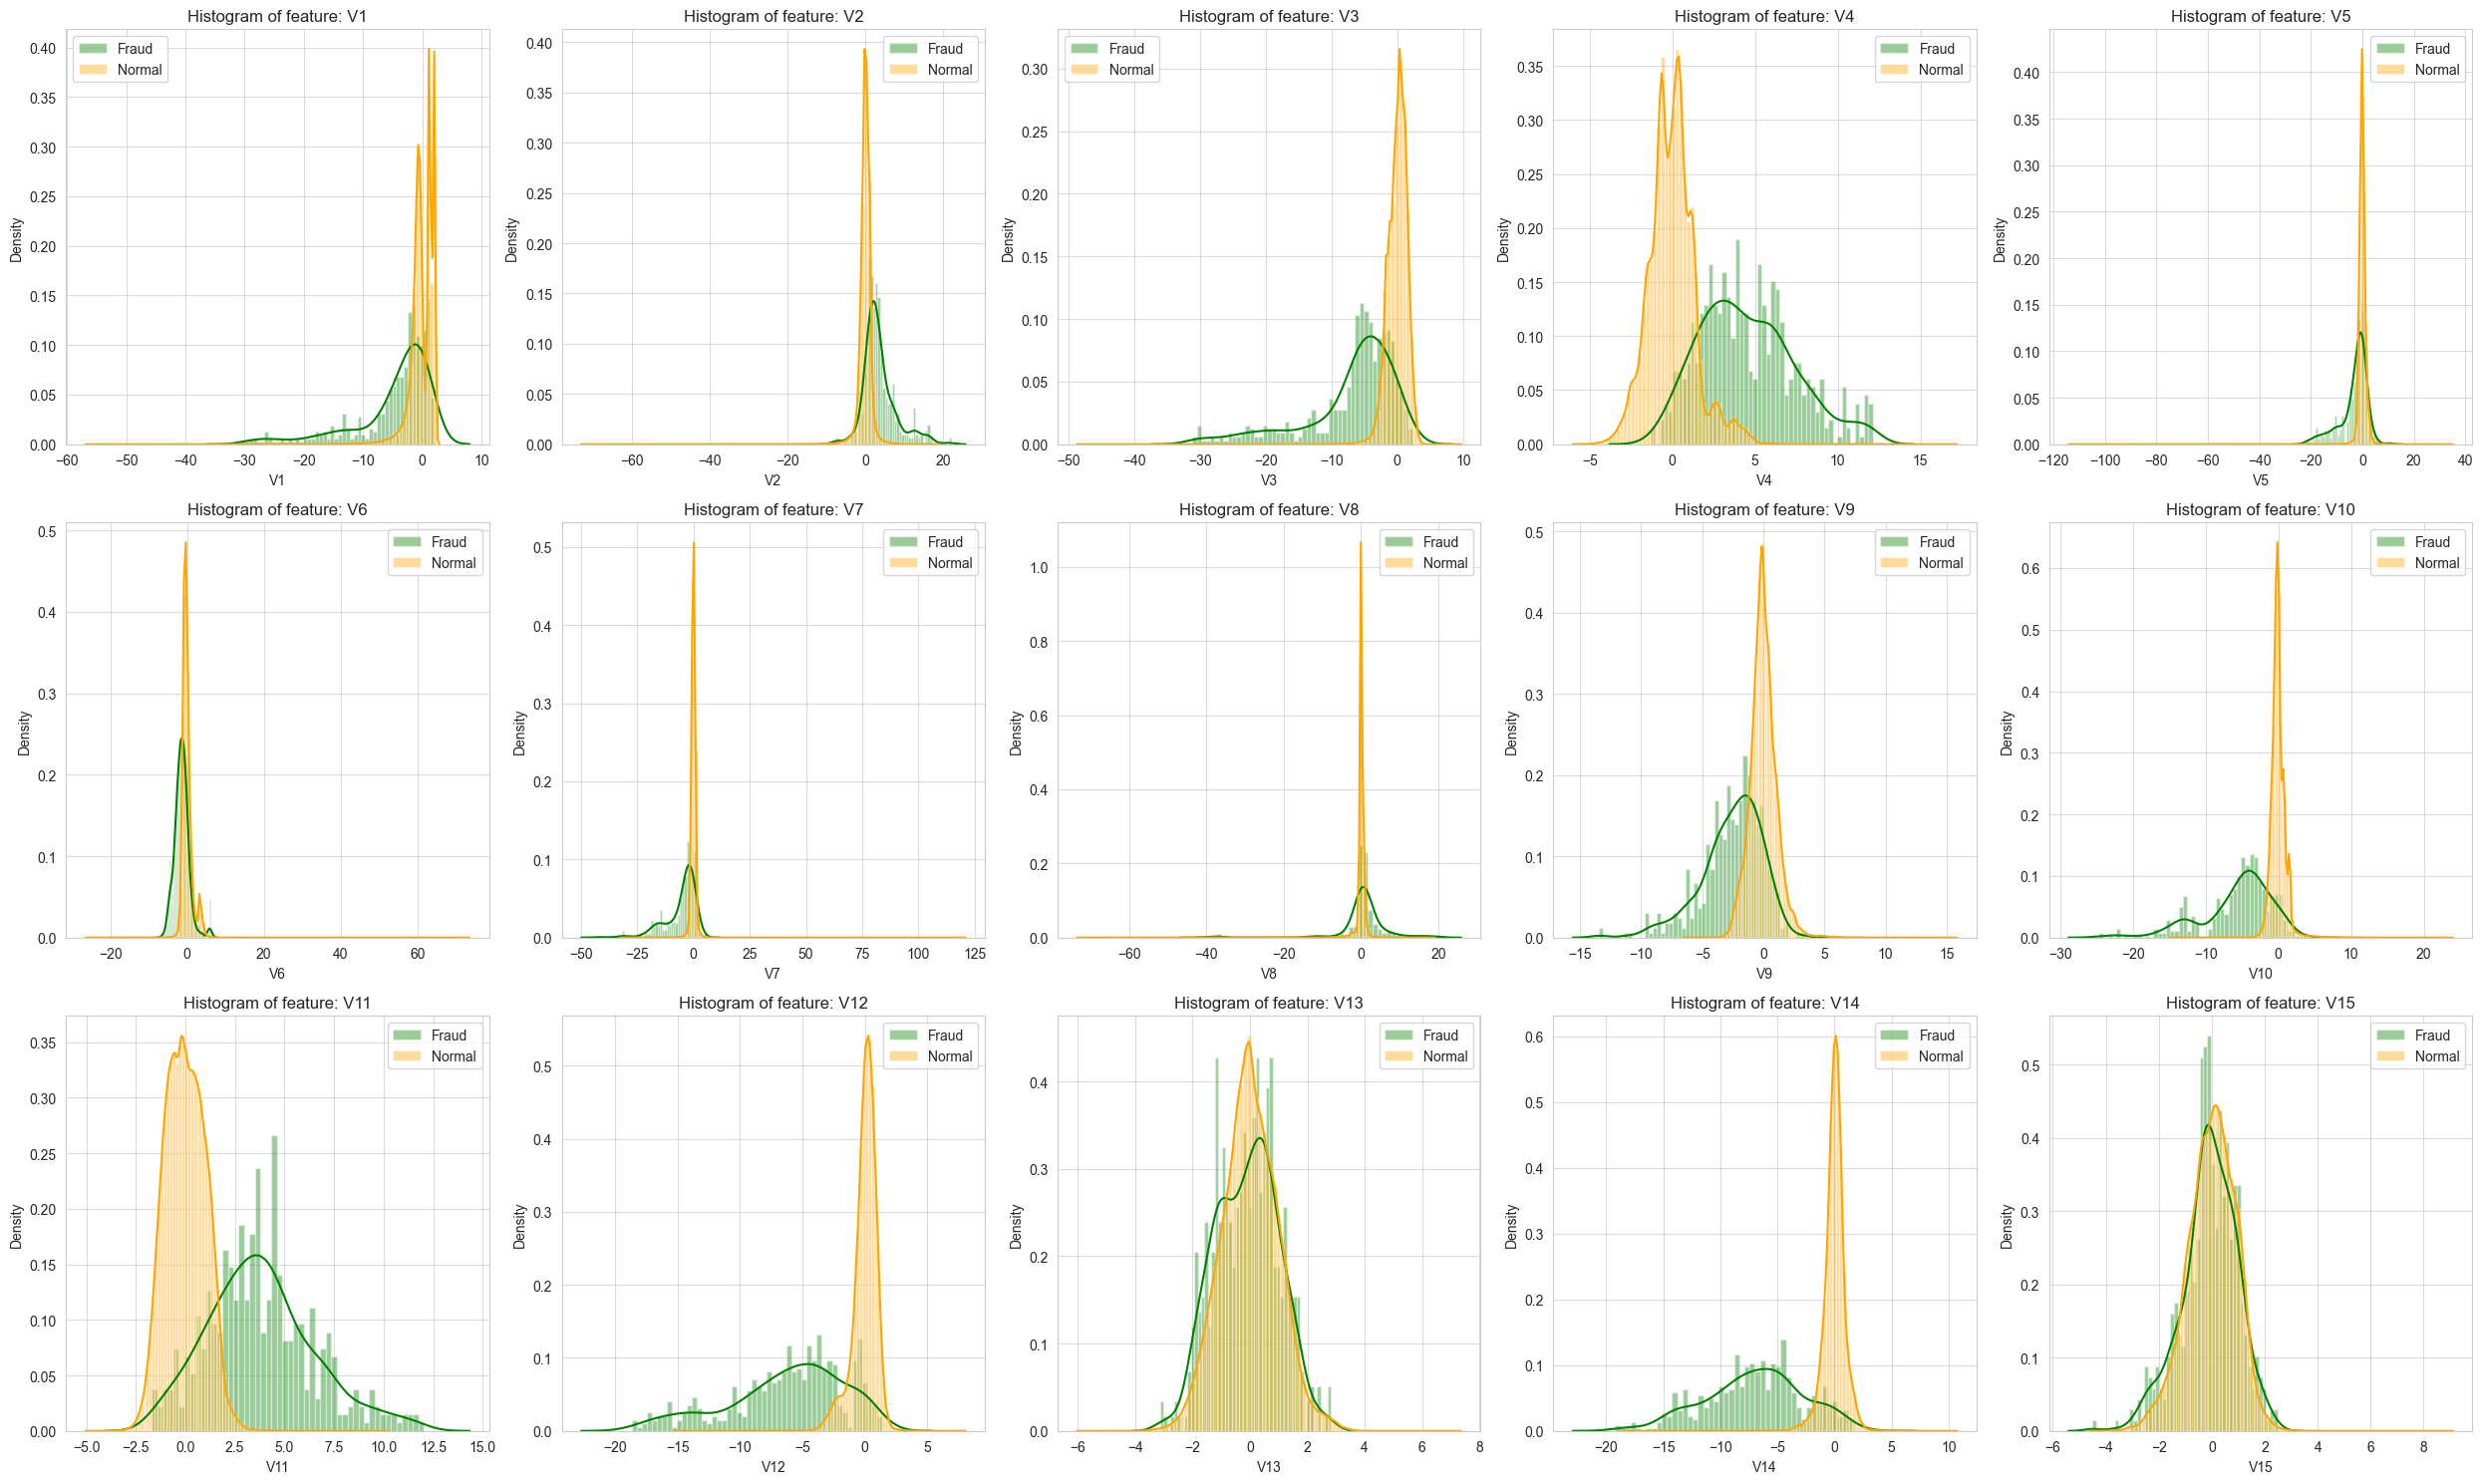

In [14]:
numeric_columns = list(df.loc[:, 'V1':'Hour'])

fig1 = plt.figure(figsize=(25, 15))
rows1, cols1 = 3, 5

for idx, num in enumerate(numeric_columns[:15]):
    ax = fig1.add_subplot(rows1, cols1, idx + 1)
    ax.grid(alpha=0.7, axis="both")
    sns.distplot(fraud_data[num], bins=50, label='Fraud', color='green')
    sns.distplot(normal_data[num], bins=100, label='Normal', color='orange')
    ax.legend()
    ax.set_xlabel(num)
    ax.set_title('Histogram of feature: ' + str(num))
    
fig1.tight_layout()
# fig1.savefig('normal_vs_fraud_part1.svg')
plt.show()

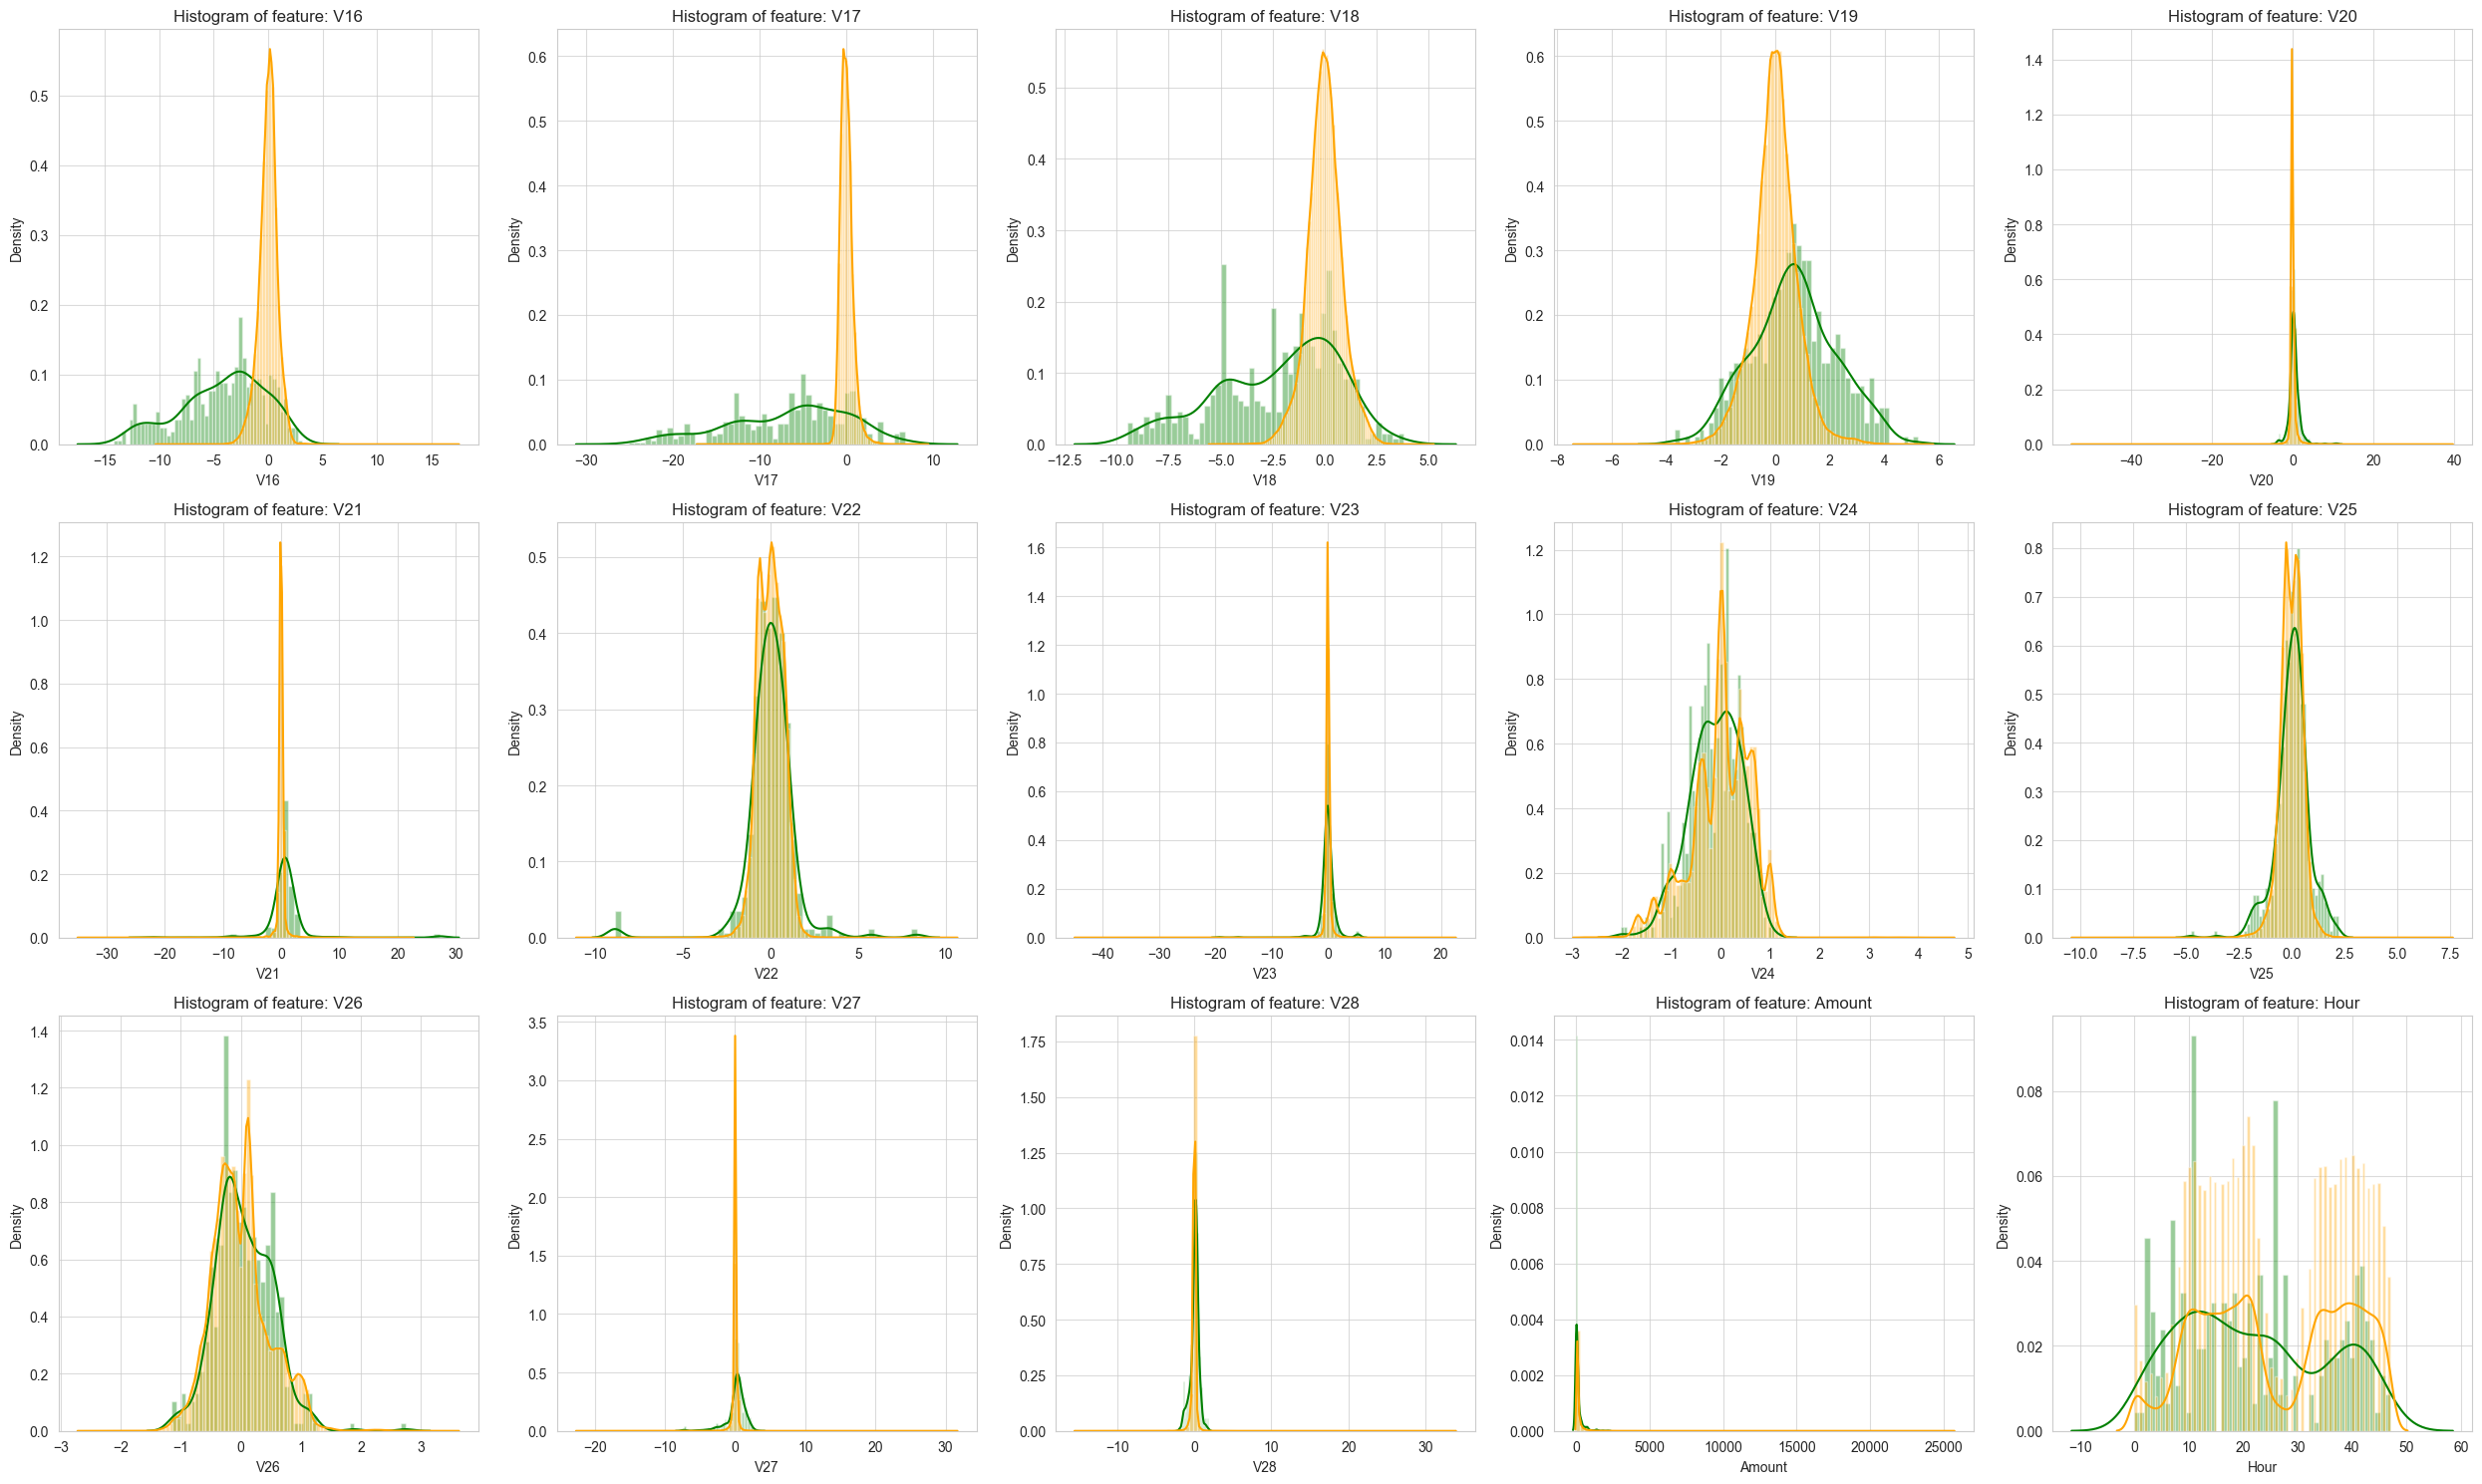

In [15]:
fig2 = plt.figure(figsize=(25, 15))
rows2, cols2 = 3, 5

for idx, num in enumerate(numeric_columns[15:30], start=1):
    ax = fig2.add_subplot(rows2, cols2, idx)
    ax.grid(alpha=0.7, axis="both")
    sns.distplot(fraud_data[num], bins=50, label='Fraud', color='green')
    sns.distplot(normal_data[num], bins=100, label='Normal', color='orange')
    if idx == 0:
        ax.legend()
    ax.set_xlabel(num)
    ax.set_title('Histogram of feature: ' + str(num))
    
fig2.tight_layout()
# fig2.savefig('normal_vs_fraud_part2.svg')
plt.show()

Based on the clear distinctions in the distributions for different credit card statuses (1-fraud; 0-normal), we have selected features that show significant separability. From the analysis above: we therefore exclude the variables V8, V13, V15, V20, V21, V22, V23, V24, V25, V26, V27, and V28 (these features do not effectively distinguish between the fraud and normal categories).

In [16]:
drop_list = ['V8', 'V13', 'V15', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Time']
df = df.drop(drop_list, axis=1)
print(df.shape)

(284807, 19)


## 2.3 DATA IMBALANCE CHECK

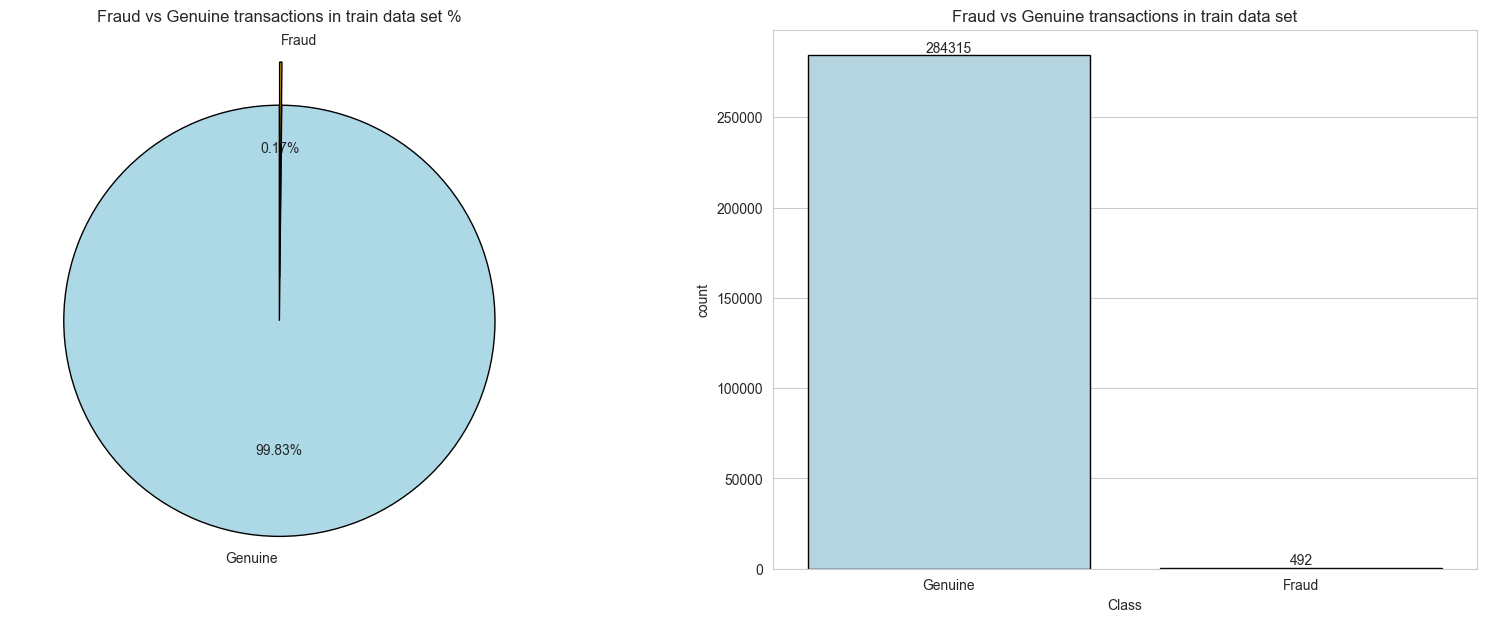

In [17]:
palette = ["#ADD8E6","#EFB000"]     

l1 = list(df['Class'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['Genuine','Fraud'], 
        autopct = '%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Fraud vs Genuine transactions in train data set %');

plt.subplot(1,2,2)
ax = sns.countplot(data = df, 
                   x='Class', 
                   palette = palette, 
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Genuine','Fraud'])
    
plt.title('Fraud vs Genuine transactions in train data set')
# plt.savefig('data_imbalance.svg')
plt.show()

We have 99,8% of Genuine transactions (284,807) and only 0,172% (492) of fraud transactions!

This means that a blind guess (bet on Genuine) would give us accuracy of 99,8%.

## 2.4 DUPLICATED VALUES

In [18]:
print('Number of duplicated values in dataset: ', df.duplicated().sum())

Number of duplicated values in dataset:  3885


In [19]:
df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")

Duplicated values dropped succesfully


In [20]:
numeric_columns = list(df.loc[:, 'V1':'Hour'])

# <a id="1"></a><center><font size = 4><span style="color:#F5F5E6"> <p style="background-color:#005F5D;font-family:courier;color:#FFFFFF;font-size:250%;text-align:center;border-radius:5px 5px;padding : 2px">MODEL BUILDING AND TRAINING</p>   </span></font></center> 

# 3. MODEL BUILDING AND TRAINING

<div class="anchor" id="top" style="
    margin-right: auto; 
    margin-left: auto;
    padding: 10px;
   font-size : 120%;
    background-color: #DFFFFE;
    border-radius: 2px;
    font-color :  #581845  ;        
    border: 2px solid #581845;">

In this part, we are going to compare 6 unsupervised anomaly detection models, including Multivariate Gaussian probability, Auto Encoders, Local Outlier Factor LOF, Isolation Forest. We will use the F1 score to evaluate the performance of each model. 

## 3.1 PREPROCESS

In [21]:
data = df.copy()
all_cols = list(data)[:]
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
scl = StandardScaler()
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (280922, 19)
normal_data  (280449, 19)
fraud_data  (473, 19)
Percent fraud  0.1727 %


In [22]:
normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(len(fraud_pca_data))])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (280449, 18)
fraud_pca_data (473, 18)
Fraud data only in Test with NONE in the training
X_train  (205449, 18)
X_test  (75473, 18)
y_test  (75473,)


Fraud goes into Test only. Train contains only normal transactions.

## 3.2 MULTI-VARIATE GAUSSIAN PROB DISTRIBUTION

In [23]:
p = multivariate_normal(mean=np.mean(X_train,axis=0), cov=np.cov(X_train.T))

x = p.pdf(X_train)
print("max prob of x on X_train", max(x))
print("mean prob of x on X_train", np.mean(x))
print('-' * 60)
MyTrain = np.mean(x)

x = p.pdf(X_test)
print("max prob of x on X_test", max(x))
print("mean prob of x on X_test", np.mean(x))
print('-' * 60)
MyTest = np.mean(x)

x = p.pdf(fraud_pca_data)
print("max prob of x on fraud_pca_data", max(x))
print("mean prob of x on fraud_pca_data", np.mean(x))
print('-' * 60)

print('Difference between mean prob of Train vs Test ', MyTrain - MyTest)

max prob of x on X_train 1.6404205296373263e-07
mean prob of x on X_train 9.23055434889874e-09
------------------------------------------------------------
max prob of x on X_test 1.6404205296373263e-07
mean prob of x on X_test 9.174541483234065e-09
------------------------------------------------------------
max prob of x on fraud_pca_data 2.119087140062709e-08
mean prob of x on fraud_pca_data 2.4835422014433217e-10
------------------------------------------------------------
Difference between mean prob of Train vs Test  5.601286566467554e-11


## Optimize Epsilon

In [24]:
# Find best epsilon re F1 score

x = p.pdf(X_test)

EpsF1 = []

epsilons = [1e-10, 1e-20, 1e-30, 1e-40, 1e-50, 1e-60, 1e-70, 1e-80, 1e-90, 1e-100, 1e-110, 1e-120,
           1e-130, 1e-140, 1e-150, 1e-160, 1e-170, 1e-180, 1e-190, 1e-200, 1e-210, 1e-220, 1e-230, 1e-240]

for e in range(len(epsilons)):
    eps = epsilons[e]
    pred = (x <= eps)
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([eps, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['epsilon', 'F1'])
EpsF1df

,epsilon,F1
0,1.000000e-10,0.0401
1,1.000000e-20,0.3418
2,1.000000e-30,0.4793
3,1.000000e-40,0.5746
4,1.000000e-50,0.6569
5,1.000000e-60,0.7074
6,1.000000e-70,0.7384
7,1.000000e-80,0.7551
8,1.000000e-90,0.7628
9,1.000000e-100,0.7781


In [25]:
# Best Epsilon ... Max F1 on val
EpsF1df.loc[EpsF1df['F1'].idxmax()]

epsilon    1.000000e-120
F1          7.855000e-01
Name: 11, dtype: float64

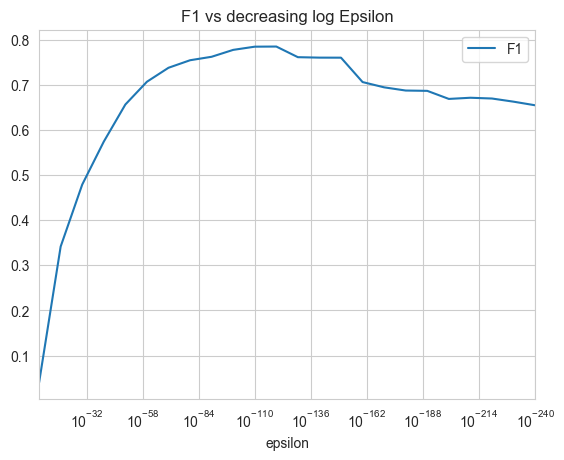

In [26]:
EpsF1df.plot.line("epsilon","F1")
plt.xscale('log')
plt.xlim(1e-10, 1e-240)
plt.title("F1 vs decreasing log Epsilon")
plt.savefig('gm.svg')
plt.show()  

In [27]:
def plot_confusion_matrix(cm, target_names, model_name,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(f'{model_name}_confusion_matrix.svg')
    plt.show()

epsilon  1e-120
__________________________________________________


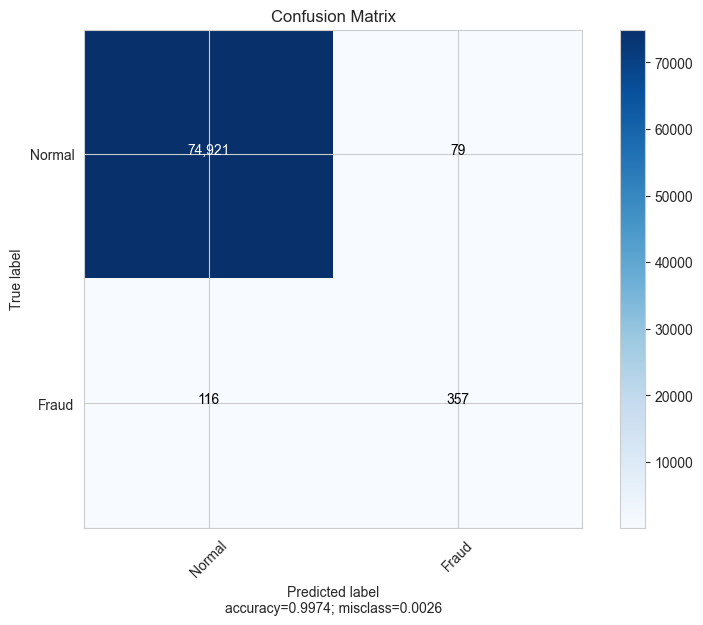

In [28]:
# CONFUSION MATRIX and F1 SCORE on Test w best epsilon
eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['epsilon']
print("epsilon ", eps)
print("_"*50)
pred = (x<=eps)
CM = confusion_matrix(y_test, pred)

plot_confusion_matrix(CM, 
                      model_name   = 'gm',
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

In [29]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     75000
         1.0       0.82      0.75      0.79       473

    accuracy                           1.00     75473
   macro avg       0.91      0.88      0.89     75473
weighted avg       1.00      1.00      1.00     75473



## 3.3 AUTOENCODER

In [30]:
data = df.copy()
all_cols = list(data)[:]
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
scl = StandardScaler()
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (280922, 19)
normal_data  (280449, 19)
fraud_data  (473, 19)
Percent fraud  0.1727 %


In [31]:
normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 75000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(len(fraud_pca_data))])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (280449, 18)
fraud_pca_data (473, 18)
Fraud data only in Test with NONE in the training
X_train  (205449, 18)
X_test  (75473, 18)
y_test  (75473,)


In [32]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [33]:
# Keras Auto Encoder model
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           266 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │           144 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 571 (2.23 KB)

 Trainable params: 571 (2.23 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
nb_epoch = 50
batch_size = 1024

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['mean_squared_error'])
cb_list = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.8, verbose=1), 
    ModelCheckpoint(filepath="model.keras", verbose=0,save_best_only=True),
]

checkpointer = ModelCheckpoint(filepath="model.keras",
                               verbose=0,
                               save_best_only=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cb_list]).history

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.5736 - mean_squared_error: 0.9288 - val_loss: 1.3538 - val_mean_squared_error: 1.0425 - learning_rate: 0.0010
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0466 - mean_squared_error: 0.8423 - val_loss: 1.0636 - val_mean_squared_error: 1.0006 - learning_rate: 0.0010
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8407 - mean_squared_error: 0.7854 - val_loss: 0.9992 - val_mean_squared_error: 0.9530 - learning_rate: 0.0010
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8106 - mean_squared_error: 0.7697 - val_loss: 0.9682 - val_mean_squared_error: 0.9314 - learning_rate: 0.0010
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7718 - mean_squared_error: 0.7387 - val_loss: 0.9488 - val_mean_squared_error: 0.9171 - learning_rate: 0.0010
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7577 - mean_squared_error: 0.7291 - val_loss: 0.9354 - val_mean_squared_error:

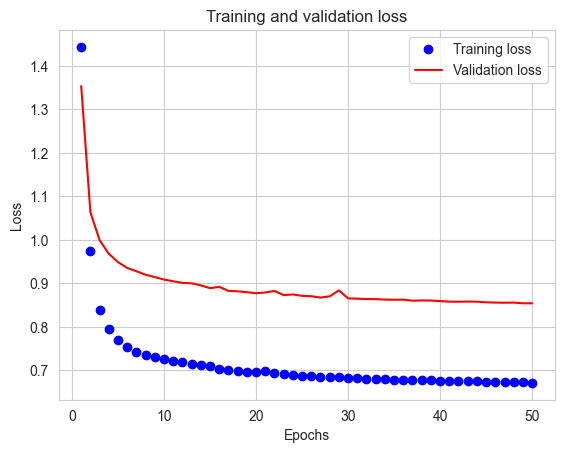

In [35]:
# VALIDATION LOSS curves
plt.clf()
history_dict = history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# Load the best model saved above during training
autoencoder = load_model('model.keras')

In [37]:
# Reconstruction error on Train
# As Train has no Fraud
y_train = np.zeros(X_train.shape[0])
predictions = autoencoder.predict(X_train)
print(predictions.shape)

mse = np.mean(np.power(X_train - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_train})
print(error_df.shape[0], ' rows')

print('mean error of recon on TRAIN', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TRAIN', round(error_df.reconstruction_error.std(),2))

6421/6421 ━━━━━━━━━━━━━━━━━━━━ 3s 444us/step
(205449, 18)
205449  rows
mean error of recon on TRAIN 0.66
std error of recon on TRAIN 3.78


In [38]:
# Reconstruction error on Test

predictions = autoencoder.predict(X_test)
print(predictions.shape)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 1s 440us/step
(75473, 18)
75473  rows
mean error of recon on TEST 0.84
std error of recon on TEST 4.18


In [39]:
y_Fraud = np.ones(fraud_pca_data.shape[0])
print(y_Fraud.shape)

predictions = autoencoder.predict(fraud_pca_data)
print(predictions.shape)

mse = np.mean(np.power(fraud_pca_data - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_Fraud})
print(error_df.shape[0], ' rows')
print('mean error of recon on FRAUD', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on FRAUD', round(error_df.reconstruction_error.std(),2))

(473,)
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
(473, 18)
473  rows
mean error of recon on FRAUD 30.7
std error of recon on FRAUD 37.27


In [40]:
predictions = autoencoder.predict(X_test)
print(predictions.shape)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
print(error_df.shape[0], ' rows')
print('mean error of recon on TEST', round(error_df.reconstruction_error.mean(),2))
print('std error of recon on TEST', round(error_df.reconstruction_error.std(),2))

ReconError = 4.0

pred = [1 if e > ReconError else 0 for e in error_df.reconstruction_error.values]
len(pred)
#pred = (x <= eps)
f = f1_score(y_test, pred, average='binary')
print("F1 score on test", round(f,4), " with reconstruction error  ", ReconError)

2359/2359 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
(75473, 18)
75473  rows
mean error of recon on TEST 0.84
std error of recon on TEST 4.18
F1 score on test 0.5361  with reconstruction error   4.0


### Optimize the reconstruction error for best F1

In [41]:
minRE = 1
maxRE = 50
    
EpsF1 = []

for TryRE in range(minRE,maxRE):
    pred = [1 if e > TryRE else 0 for e in error_df.reconstruction_error.values]
    f = f1_score(y_test, pred, average='binary')
    #print("F1 score on test", round(f,4), " with epsilon ", eps)
    EpsF1.append([TryRE, round(f,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['ReconError', 'F1'])
EpsF1df

,ReconError,F1
0,1,0.0873
1,2,0.3018
2,3,0.4389
3,4,0.5361
4,5,0.5874
5,6,0.6130
6,7,0.6217
7,8,0.5980
8,9,0.6116
9,10,0.6150


In [42]:
# Best Recon Error ... Max F1 on test
EpsF1df.loc[EpsF1df['F1'].idxmax()]

ReconError    7.0000
F1            0.6217
Name: 6, dtype: float64

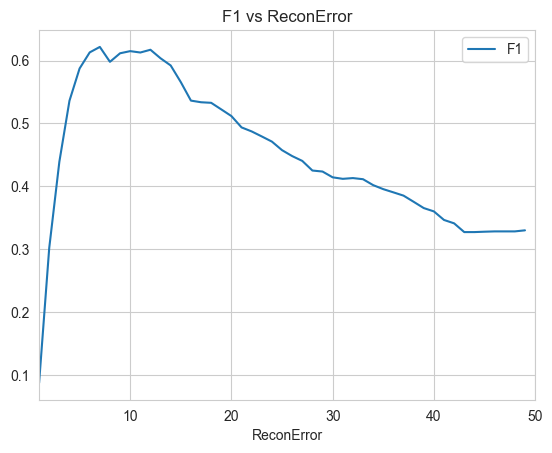

In [43]:
EpsF1df.plot.line("ReconError","F1")
plt.xlim(1, 50)
plt.title("F1 vs ReconError")
plt.savefig('autoencoder.svg')
plt.show()

epsilon  7.0
__________________________________________________


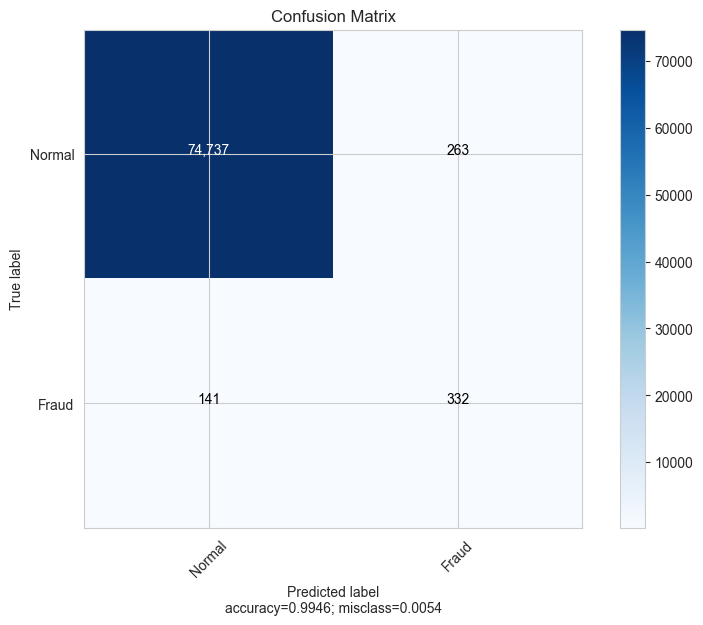

In [44]:
# CONFUSION MATRIX and F1 SCORE on Test w best epsilon
eps = EpsF1df.loc[EpsF1df['F1'].idxmax()]['ReconError']
print("epsilon ", eps)
pred = [1 if e > eps else 0 for e in error_df.reconstruction_error.values]
print("_"*50)
CM = confusion_matrix(y_test, pred)

plot_confusion_matrix(CM, 
                      model_name   = 'ae',
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

## 3.4 LOCAL OUTLIER FACTOR

In [45]:
#  SCALER / Normalization

data = df.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (280922, 19)
normal_data  (280449, 19)
fraud_data  (473, 19)
Percent fraud  0.1727 %


In [46]:
normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 20000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(len(fraud_pca_data))])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (280449, 18)
fraud_pca_data (473, 18)
Fraud data only in Test with NONE in the training
X_train  (260449, 18)
X_test  (20473, 18)
y_test  (20473,)


In [47]:
X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)

X_inliers  (20000, 18)
X_outliers  (473, 18)
X  (20473, 18)
n_outliers  473
percent fraud in test:  0.023103599863234504


In [48]:
# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination = PercFraud)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_
n_errors

892

In [49]:
print('accuracy ' , round(1 - (n_errors / X.shape[0]),4))

accuracy  0.9564


In [50]:
# Note that the ground truth and the y_pred for LOF is different than the original ... inliers = normal = 1 and outliers = fraud = -1
# We have to modify the y_pred for the F1 score calculation to be similar to the above 

y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)
print(y_predDF[y_predDF[0] == -1].count())

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1
print(y_predDF[y_predDF[0] == 1].count())

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)

0    473
dtype: int64
0    473
dtype: int64


In [51]:
print(classification_report(y_predLOF, y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     20000
           1       0.06      0.06      0.06       473

    accuracy                           0.96     20473
   macro avg       0.52      0.52      0.52     20473
weighted avg       0.96      0.96      0.96     20473



In [52]:
# Optimize num of neighbors hyper paramter for best F1

minRE = 500
maxRE = 1500
    
EpsF1 = []

for TryRE in range(minRE,maxRE,100):
    clf = LocalOutlierFactor(n_neighbors=TryRE, contamination = PercFraud)
    y_pred = clf.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    X_scores = clf.negative_outlier_factor_
    
    y_predLOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predLOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predLOF = y_predDF.values
    y_predLOF = np.ravel(y_predLOF)
    
    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predLOF, average='binary')
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumNeighb', 'F1'])
EpsF1df

,NumNeighb,F1
0,500,0.7463
1,600,0.7717
2,700,0.7780
3,800,0.7844
4,900,0.7844
5,1000,0.7844
6,1100,0.7822
7,1200,0.7780
8,1300,0.7738
9,1400,0.7653


In [53]:
# Best Recon Error ... Max F1 on test
EpsF1df.loc[EpsF1df['F1'].idxmax()]

NumNeighb    800.0000
F1             0.7844
Name: 3, dtype: float64

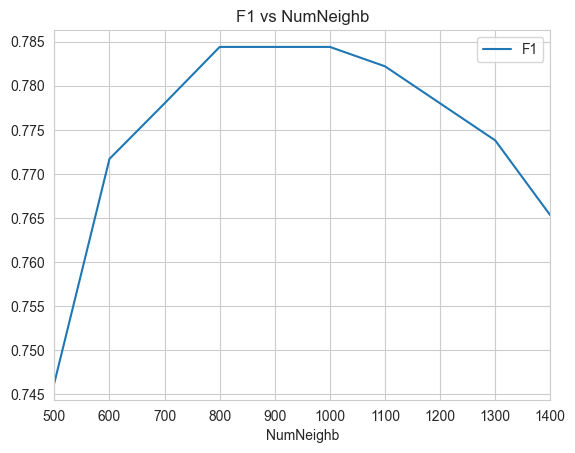

In [54]:
EpsF1df.plot.line("NumNeighb","F1")
plt.xlim(500, 1400)
plt.title("F1 vs NumNeighb")
plt.savefig('lof.svg')
plt.show()

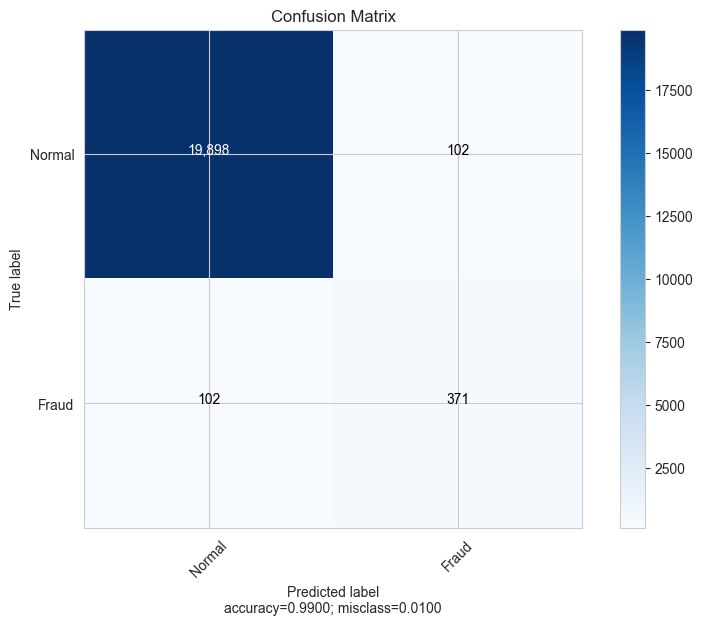

In [55]:
clf = LocalOutlierFactor(n_neighbors=800, contamination = PercFraud)
y_pred = clf.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

y_predLOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predLOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predLOF = y_predDF.values
y_predLOF = np.ravel(y_predLOF)


CM = confusion_matrix(y_test, y_predLOF)
plot_confusion_matrix(CM, 
                      model_name   = 'lof',
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")

## 3.5 ISOLATION FOREST

In [56]:
#  SCALER / Normalization
data = df.copy()
scl = StandardScaler()
all_cols = list(data)[:] 
pca_columns = list(data)[:-1] # all cols without Class
Xcopy = data[pca_columns]
XcopyALL = data[all_cols]
Xscaled = scl.fit_transform(Xcopy)
OnlyClass = data['Class'].values.reshape(-1,1)
data = np.concatenate((Xscaled, OnlyClass), axis=1)
data = pd.DataFrame(data, columns = XcopyALL.columns)

normal_data = data.loc[data["Class"] == 0]
fraud_data = data.loc[data["Class"] == 1]

print("data ", data.shape)
print("normal_data ", normal_data.shape)
print("fraud_data ", fraud_data.shape)
print("Percent fraud ", round(100*492/284807, 4),"%")

data  (280922, 19)
normal_data  (280449, 19)
fraud_data  (473, 19)
Percent fraud  0.1727 %


In [57]:
normal_pca_data = normal_data[pca_columns]
fraud_pca_data = fraud_data[pca_columns]

num_test = 20000
shuffled_data = normal_pca_data.sample(frac=1, random_state=1960)[:-num_test].values
X_train = shuffled_data

X_test = np.concatenate([shuffled_data[-num_test:], fraud_pca_data[:]])
y_test = np.concatenate([np.zeros(num_test), np.ones(len(fraud_pca_data))])

print("normal_pca_data ", normal_pca_data.shape)
print("fraud_pca_data", fraud_pca_data.shape)
print("Fraud data only in Test with NONE in the training")
print("X_train ", X_train.shape)
print("X_test ", X_test.shape)
print("y_test ", y_test.shape)

normal_pca_data  (280449, 18)
fraud_pca_data (473, 18)
Fraud data only in Test with NONE in the training
X_train  (260449, 18)
X_test  (20473, 18)
y_test  (20473,)


In [58]:
X_inliers = shuffled_data[-num_test:]
X_outliers = fraud_pca_data[:]
X = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

PercFraud = n_outliers / X_test.shape[0]

print('X_inliers ', X_inliers.shape)
print('X_outliers ', X_outliers.shape)
print('X ', X.shape)
print('n_outliers ', n_outliers)
print('percent fraud in test: ', PercFraud)

X_inliers  (20000, 18)
X_outliers  (473, 18)
X  (20473, 18)
n_outliers  473
percent fraud in test:  0.023103599863234504


In [59]:
isofo = IsolationForest(n_estimators = 1050, max_features = 1.0, max_samples=1.0,
                        bootstrap=False, random_state=22,
                        contamination = PercFraud)

y_pred = isofo.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()
print(n_errors)

324


In [60]:
y_predISOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predISOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predISOF = y_predDF.values
y_predISOF = np.ravel(y_predISOF)

print(classification_report(y_test, y_predISOF))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     20000
         1.0       0.66      0.66      0.66       473

    accuracy                           0.98     20473
   macro avg       0.82      0.82      0.82     20473
weighted avg       0.98      0.98      0.98     20473



In [61]:
# Optimize Num Estimators hyper paramter for best F1

minRE = 500
maxRE = 1500
    
EpsF1 = []

for TryRE in np.arange(minRE, maxRE, 100):
    isofo = IsolationForest(n_estimators = TryRE, max_features = 1.0, max_samples=1.0, 
                        bootstrap=False, random_state=22,
                        contamination = PercFraud)

    y_pred = isofo.fit_predict(X)
    n_errors = (y_pred != ground_truth).sum()
    
    y_predISOF = y_pred.copy()
    y_predDF = pd.DataFrame(y_predISOF)
    
    y_predDF[y_predDF[0] == 1] = 0
    y_predDF[y_predDF[0] == -1] = 1
    
    y_predISOF = y_predDF.values
    y_predISOF = np.ravel(y_predISOF)

    precision,recall,fbeta_score, support  = precision_recall_fscore_support(y_test, y_predISOF, average='binary')
    
    EpsF1.append([TryRE, round(fbeta_score,4)])
    
EpsF1df = pd.DataFrame(EpsF1, columns = ['NumEstim', 'F1'])
EpsF1df

,NumEstim,F1
0,500,0.6575
1,600,0.6596
2,700,0.6575
3,800,0.6575
4,900,0.6554
5,1000,0.6554
6,1100,0.6554
7,1200,0.6575
8,1300,0.6575
9,1400,0.6575


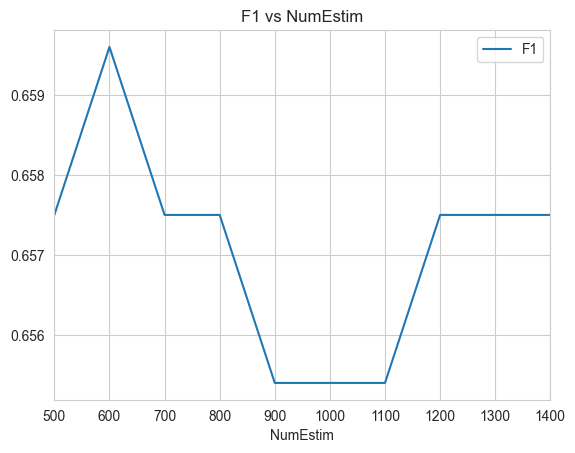

In [62]:
EpsF1df.plot.line("NumEstim","F1")
plt.xlim(500, 1400)
plt.title("F1 vs NumEstim")
plt.savefig('isoforest.svg')
plt.show()

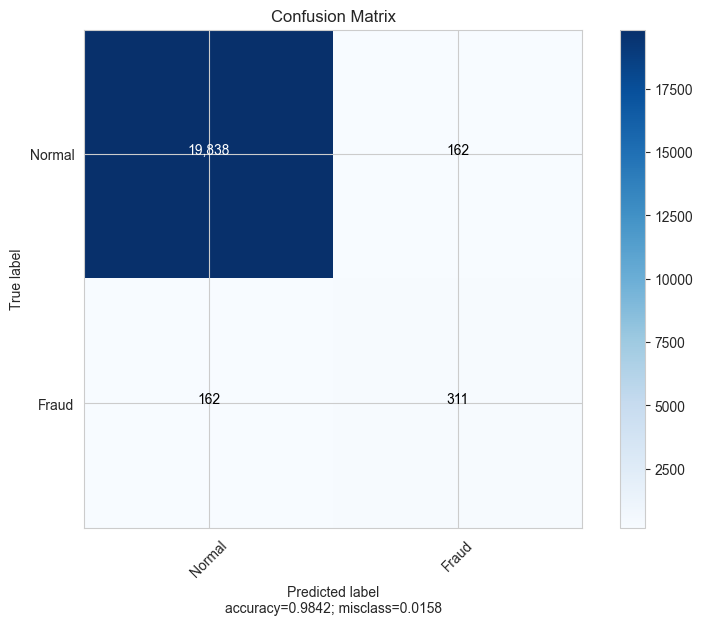

In [63]:
isofo = IsolationForest(n_estimators = TryRE, max_features = 1.0, max_samples=1.0, 
                        bootstrap=False, random_state=22,
                        contamination = PercFraud)

y_pred = isofo.fit_predict(X)
n_errors = (y_pred != ground_truth).sum()

y_predISOF = y_pred.copy()
y_predDF = pd.DataFrame(y_predISOF)

y_predDF[y_predDF[0] == 1] = 0
y_predDF[y_predDF[0] == -1] = 1

y_predISOF = y_predDF.values
y_predISOF = np.ravel(y_predISOF)

CM = confusion_matrix(y_test, y_predISOF)
plot_confusion_matrix(CM, 
                      model_name   = 'isof',
                      normalize    = False,
                      target_names = ['Normal', 'Fraud'],
                      title        = "Confusion Matrix")


# 4. CONCLUSIONS

- When it comes to model evaluation metrics, recall and precision serve different purposes depending on the application. For instance, in news text classification, we might prioritize high accuracy, meaning that the predicted categories for news articles should be highly accurate. However, in scenarios like credit card fraud detection, where the goal is to capture as many fraudulent transactions as possible (even at the cost of some false alarms), recall becomes the primary concern.
- In binary classification, setting the threshold for predicting a sample's class is not fixed but rather depends on business objectives. Different thresholds will affect both recall and precision, so the choice depends on which metric is more important for the specific application. For credit card fraud, for instance, a higher recall is often preferred, meaning that we aim to flag potentially fraudulent transactions as much as possible.
- Feature engineering plays a crucial role, especially with engineered features like V1 through V28, which can significantly impact model performance. Ultimately, the quality and relevance of the data are paramount for building effective models..
